In [106]:
import pandas as pd
import numpy as np
import sklearn

import pandas_datareader.data as web
import datetime as dt
import quandl

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score

import scikitplot as skplt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Gathering Initial Data for MVP

In [2]:
#Defining start and end date for pandas data reader
start = dt.datetime(1950, 1, 1)
end = dt.datetime(2019, 8, 31)

In [3]:
#Getting FRED datastreams using DataReader
fred = web.DataReader(['GS10', 'TB3MS', 'USREC', 'CSCICP03USM665S'], 'fred', start, end)
fred.reset_index(drop = False, inplace = True)
fred.columns = ['Date','10_Year','3_Month','Recession','Consumer Sentiment']

In [4]:
#Making new column for 10 Year, 3 Month yield spread
fred['10Y-3M'] = fred['10_Year'] - fred['3_Month']

In [5]:
#Need each row to have full set of data
fred.dropna(inplace = True)
fred.reset_index(drop = True, inplace = True)

In [6]:
#Formating dates to Year/month to merge dataframes easily
fred['Date'] = fred['Date'].dt.strftime('%Y-%m')

In [7]:
fred.iloc[102:110]

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M
102,1968-07,5.50,5.31,0,100.612032,0.19
103,1968-08,5.42,5.09,0,100.596721,0.33
104,1968-09,5.46,5.19,0,100.603771,0.27
105,1968-10,5.58,5.35,0,100.677831,0.23
106,1968-11,5.70,5.45,0,100.851819,0.25
107,1968-12,6.03,5.96,0,101.045913,0.07
108,1969-01,6.04,6.14,0,101.143826,-0.10
109,1969-02,6.19,6.12,0,101.048971,0.07


In [8]:
#Getting copper and gold datastreams using DataReader
#End goal is to find copper/gold ratio
metals = quandl.get(['CHRIS/CME_HG2','LBMA/GOLD'], collapse = 'monthly')
metals.reset_index(drop = False, inplace = True)

In [9]:
metals = metals[['Date','CHRIS/CME_HG2 - Settle','LBMA/GOLD - USD (AM)']]
metals.columns = ['Date', 'Copper', 'Gold']

In [10]:
metals.dropna(inplace = True)
metals.reset_index(drop = True, inplace = True)
metals['Date'] = metals['Date'].dt.strftime('%Y-%m')

In [11]:
metals['Copper/Gold'] = np.log(metals['Copper'] / metals['Gold'])
metals = metals[['Date','Copper/Gold']].copy()

In [12]:
metals.head(3)

,Date,Copper/Gold
0,1968-07,-4.488816
1,1968-08,-4.493680
2,1968-09,-4.420542


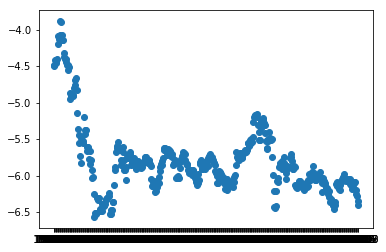

In [13]:
plt.scatter(metals['Date'], metals['Copper/Gold'])

In [14]:
df = (pd.merge(fred, metals, on='Date'))
df['Date'] = pd.to_datetime(df['Date'])

In [15]:
df.head(15)

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold
0,1968-07-01,5.50,5.31,0,100.612032,0.19,-4.488816
1,1968-08-01,5.42,5.09,0,100.596721,0.33,-4.493680
2,1968-09-01,5.46,5.19,0,100.603771,0.27,-4.420542
3,1968-10-01,5.58,5.35,0,100.677831,0.23,-4.460540
4,1968-11-01,5.70,5.45,0,100.851819,0.25,-4.426410
5,1968-12-01,6.03,5.96,0,101.045913,0.07,-4.405909
6,1969-07-01,6.72,7.00,0,99.919902,-0.28,-4.191297
7,1969-08-01,6.69,6.98,0,99.678861,-0.29,-4.081967
8,1969-09-01,7.16,7.09,0,99.441214,0.07,-4.124309
9,1969-10-01,7.10,7.00,0,99.244004,0.10,-4.076685


## EDA

Have to shift yield spreads forward a certain amount of time to see if spreads have any predictive power
into future

Let's start with 6 months, 9 months, and 12 months

In [16]:
df['10Y-3M 6M Forward'] = df.loc[:,'10Y-3M'].shift(periods=6)
df['10Y-3M 9M Forward'] = df.loc[:,'10Y-3M'].shift(periods=9)
df['10Y-3M 12M Forward'] = df.loc[:,'10Y-3M'].shift(periods=12)

df['C Sentiment 6M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=6)
df['C Sentiment 9M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=9)
df['C Sentiment 12M Forward'] = df.loc[:,'Consumer Sentiment'].shift(periods=12)

df['C/G 6M Forward'] = df.loc[:,'Copper/Gold'].shift(periods=6)
df['C/G 9M Forward'] = df.loc[:,'Copper/Gold'].shift(periods=9)
df['C/G 12M Forward'] = df.loc[:,'Copper/Gold'].shift(periods=12)

In [17]:
df.head(5)

,Date,10_Year,3_Month,Recession,Consumer Sentiment,10Y-3M,Copper/Gold,10Y-3M 6M Forward,10Y-3M 9M Forward,10Y-3M 12M Forward,C Sentiment 6M Forward,C Sentiment 9M Forward,C Sentiment 12M Forward,C/G 6M Forward,C/G 9M Forward,C/G 12M Forward
0,1968-07-01,5.50,5.31,0,100.612032,0.19,-4.488816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968-08-01,5.42,5.09,0,100.596721,0.33,-4.493680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968-09-01,5.46,5.19,0,100.603771,0.27,-4.420542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968-10-01,5.58,5.35,0,100.677831,0.23,-4.460540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968-11-01,5.70,5.45,0,100.851819,0.25,-4.426410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# df.dropna(inplace = True)
# df = df.drop(['10Y-2Y', '10Y-3M'], axis=1)

In [19]:
df.to_pickle("Data/df.pkl")

Quick EDA and time series plots of the spread's predicition ability

First take a look at features w/ no lag vs. recessions

/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


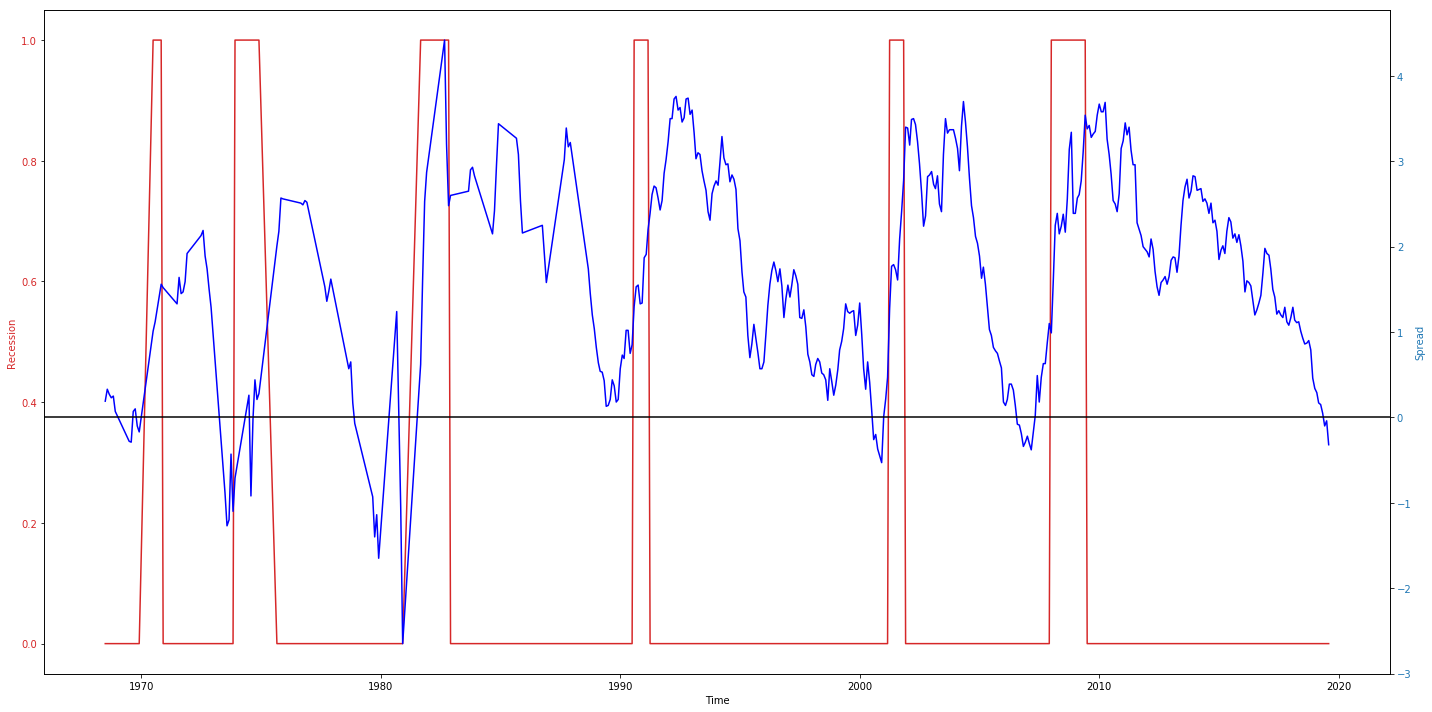

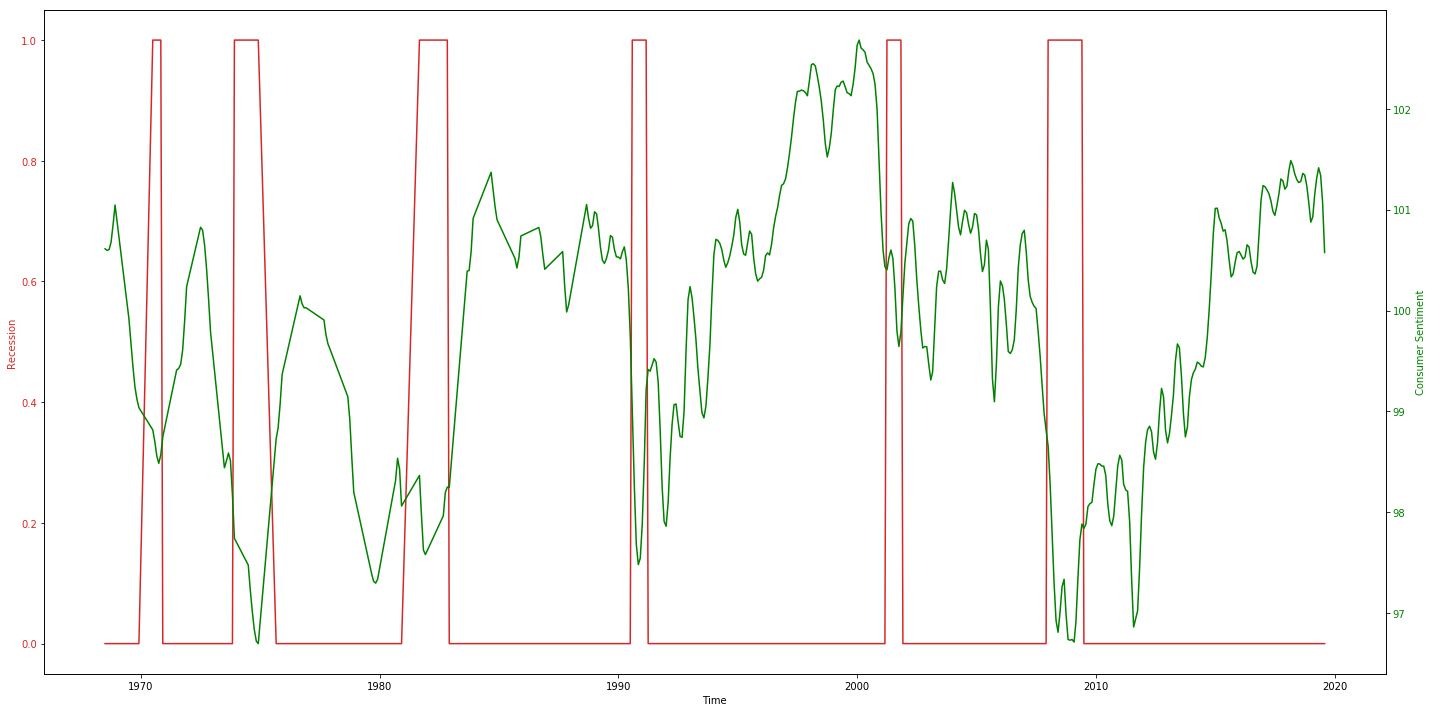

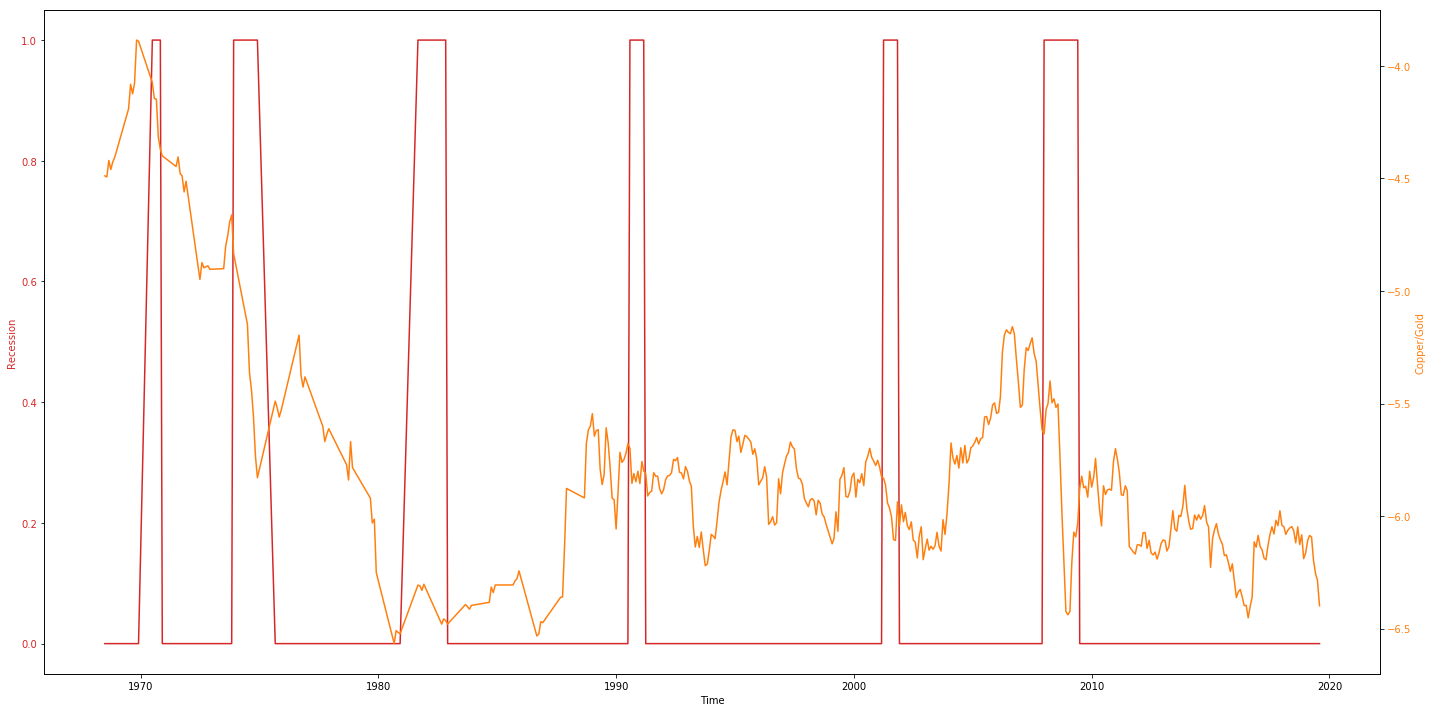

In [20]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['Consumer Sentiment'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show()

fig3, ax5 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax5.set_xlabel('Time')
ax5.set_ylabel('Recession', color=color)
ax5.plot(df['Date'], df['Recession'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

ax6 = ax5.twinx()  

color = 'tab:orange'
ax6.set_ylabel('Copper/Gold', color=color)  
ax6.plot(df['Date'], df['Copper/Gold'], color=color)
ax6.tick_params(axis='y', labelcolor=color)

fig3.tight_layout()
plt.show();

Certainly seems like spreads have led the last few recessions. Now let's look at predictative ability of spreads for 6m

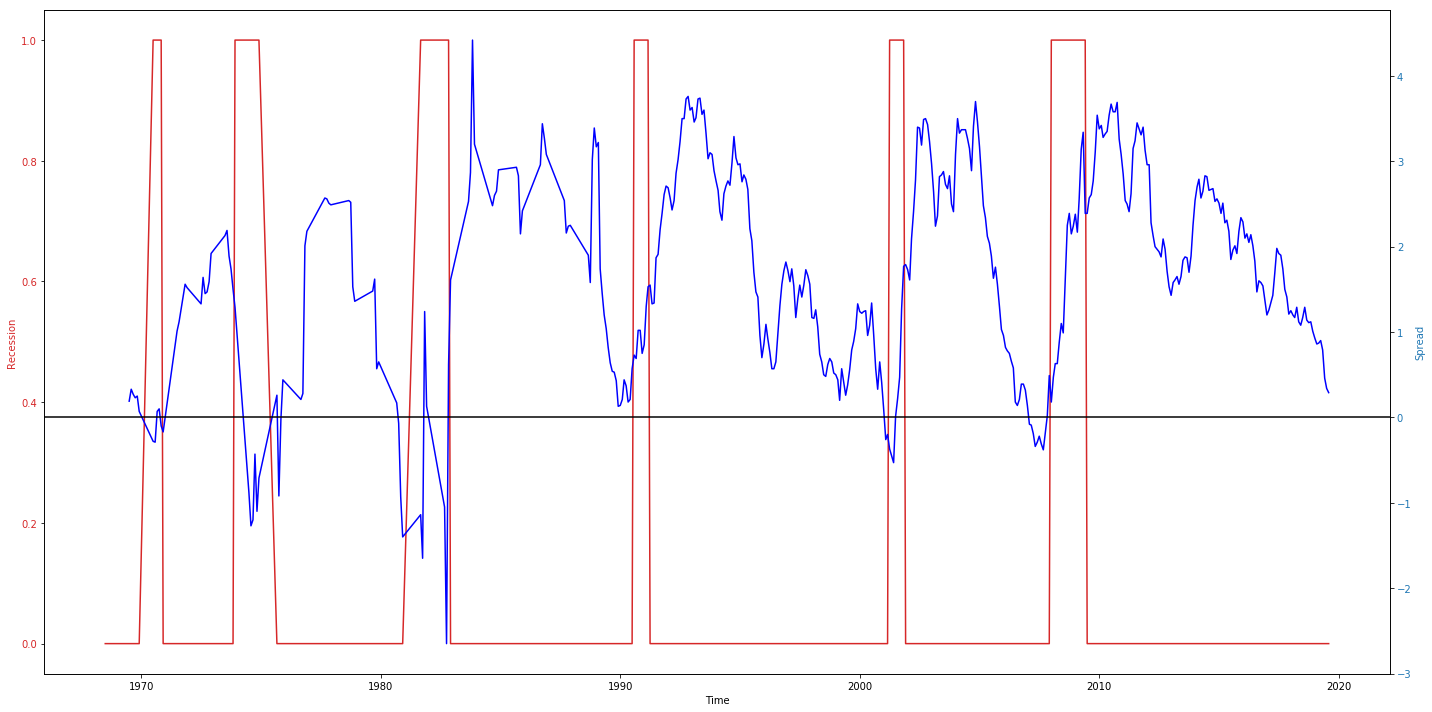

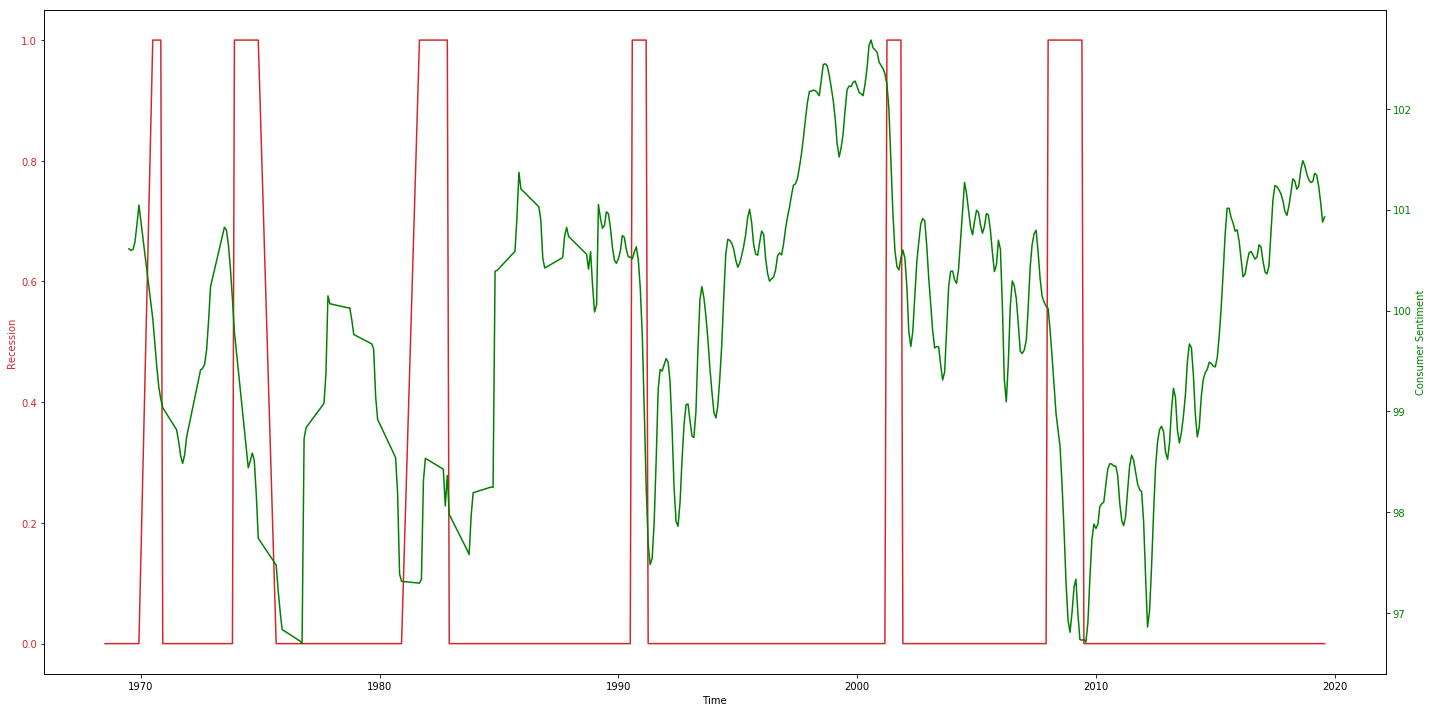

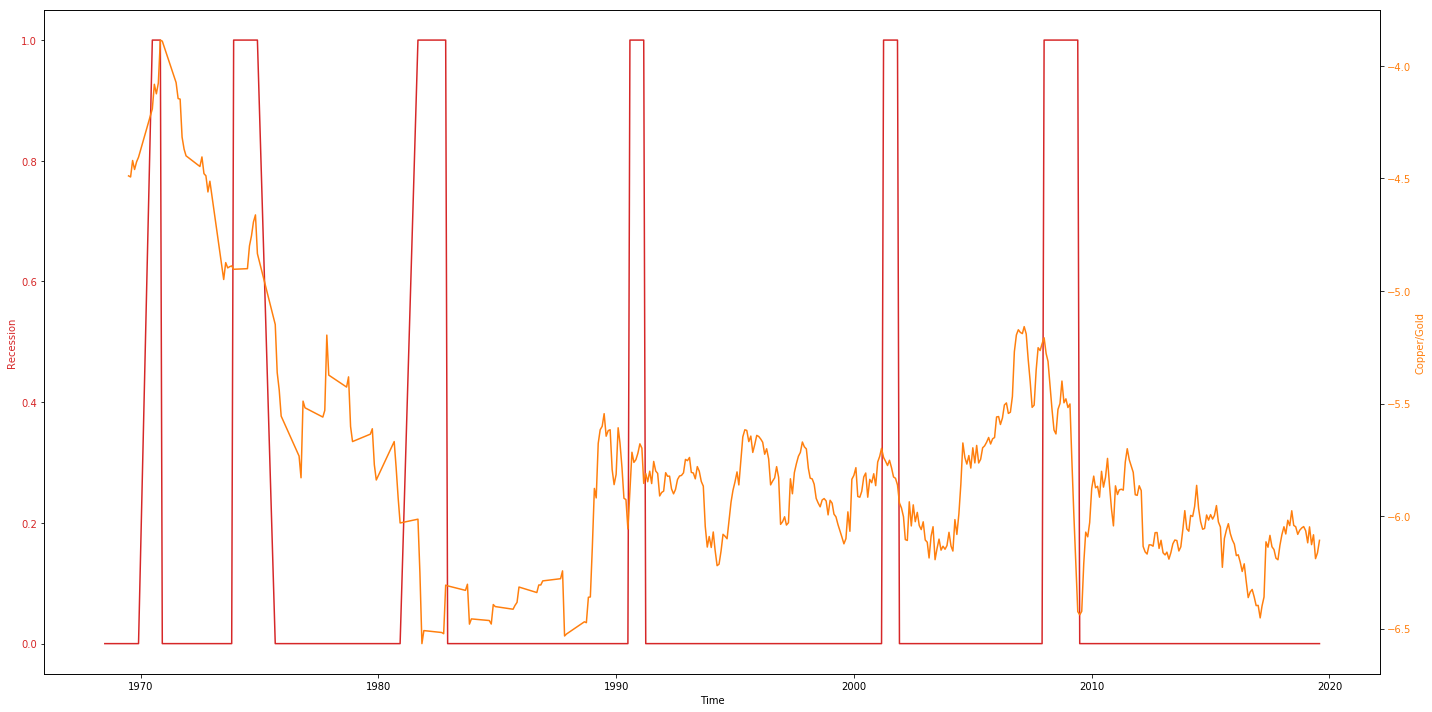

In [21]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 6M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 6M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show()

fig3, ax5 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax5.set_xlabel('Time')
ax5.set_ylabel('Recession', color=color)
ax5.plot(df['Date'], df['Recession'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

ax6 = ax5.twinx()  

color = 'tab:orange'
ax6.set_ylabel('Copper/Gold', color=color)  
ax6.plot(df['Date'], df['C/G 6M Forward'], color=color)
ax6.tick_params(axis='y', labelcolor=color)

fig3.tight_layout()
plt.show();

Not bad. Let's try 9 months too

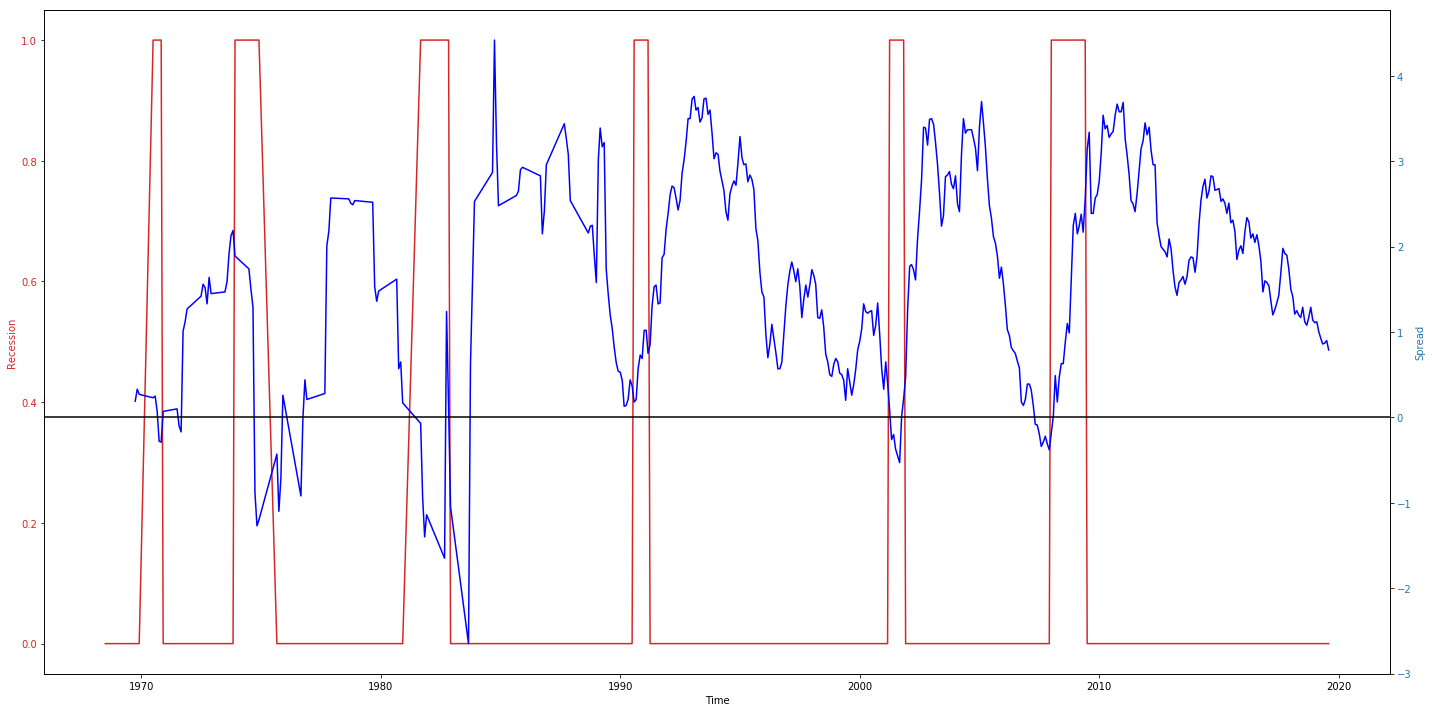

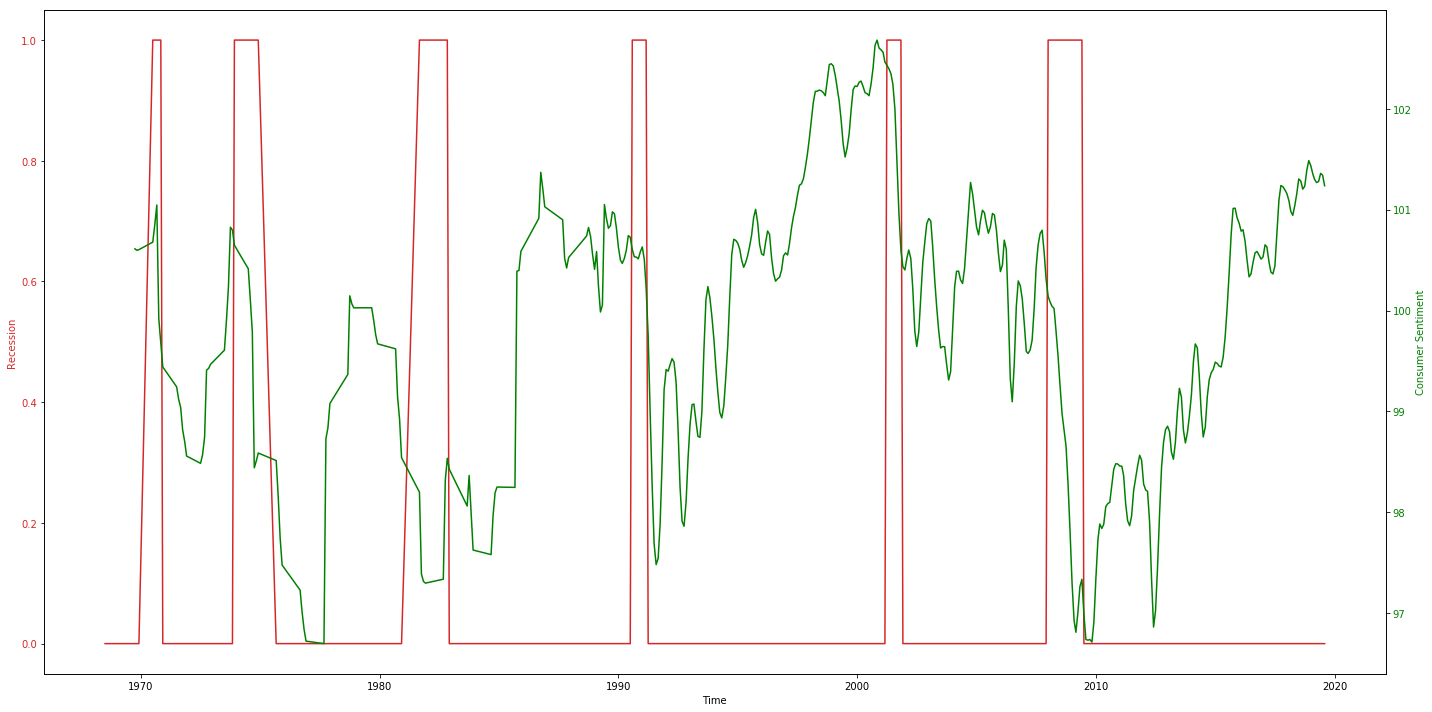

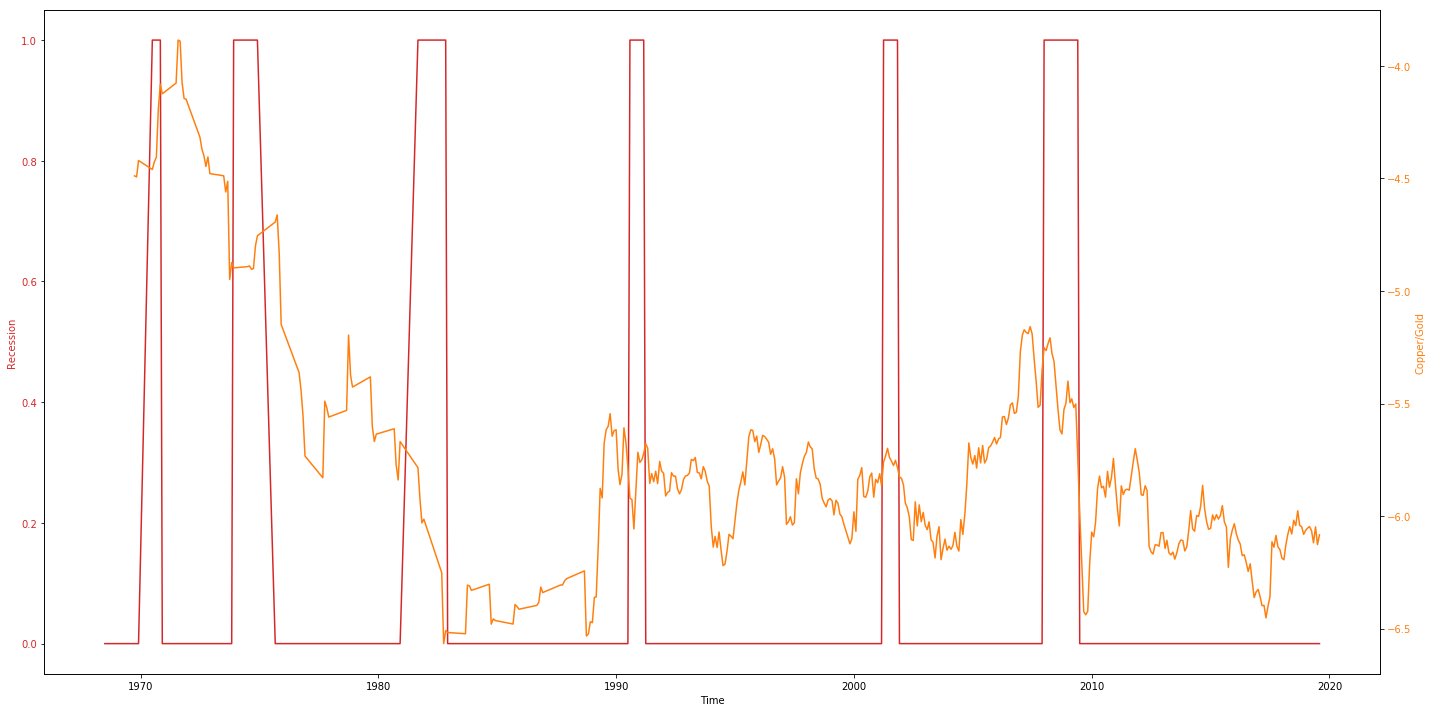

In [22]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 9M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 9M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show()

fig3, ax5 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax5.set_xlabel('Time')
ax5.set_ylabel('Recession', color=color)
ax5.plot(df['Date'], df['Recession'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

ax6 = ax5.twinx()  

color = 'tab:orange'
ax6.set_ylabel('Copper/Gold', color=color)  
ax6.plot(df['Date'], df['C/G 9M Forward'], color=color)
ax6.tick_params(axis='y', labelcolor=color)

fig3.tight_layout()
plt.show();

And one last time for 12 months

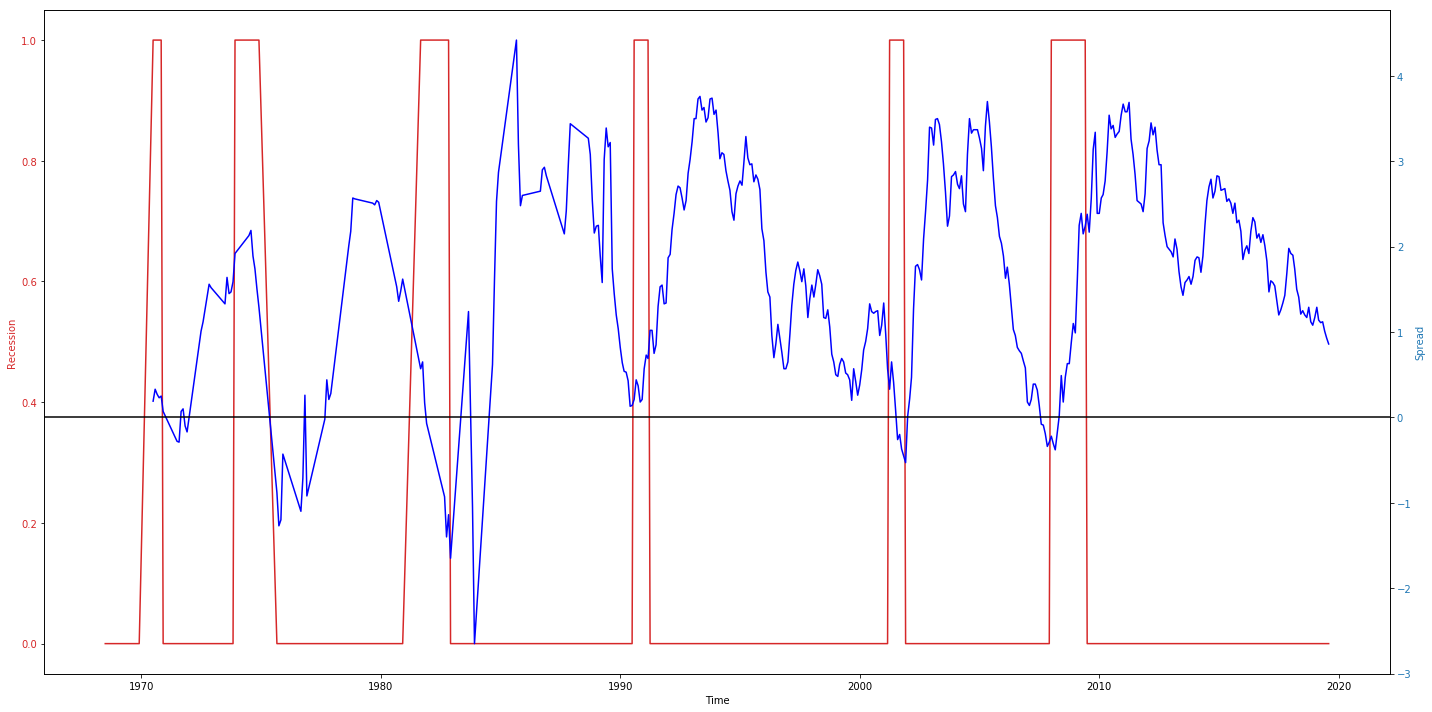

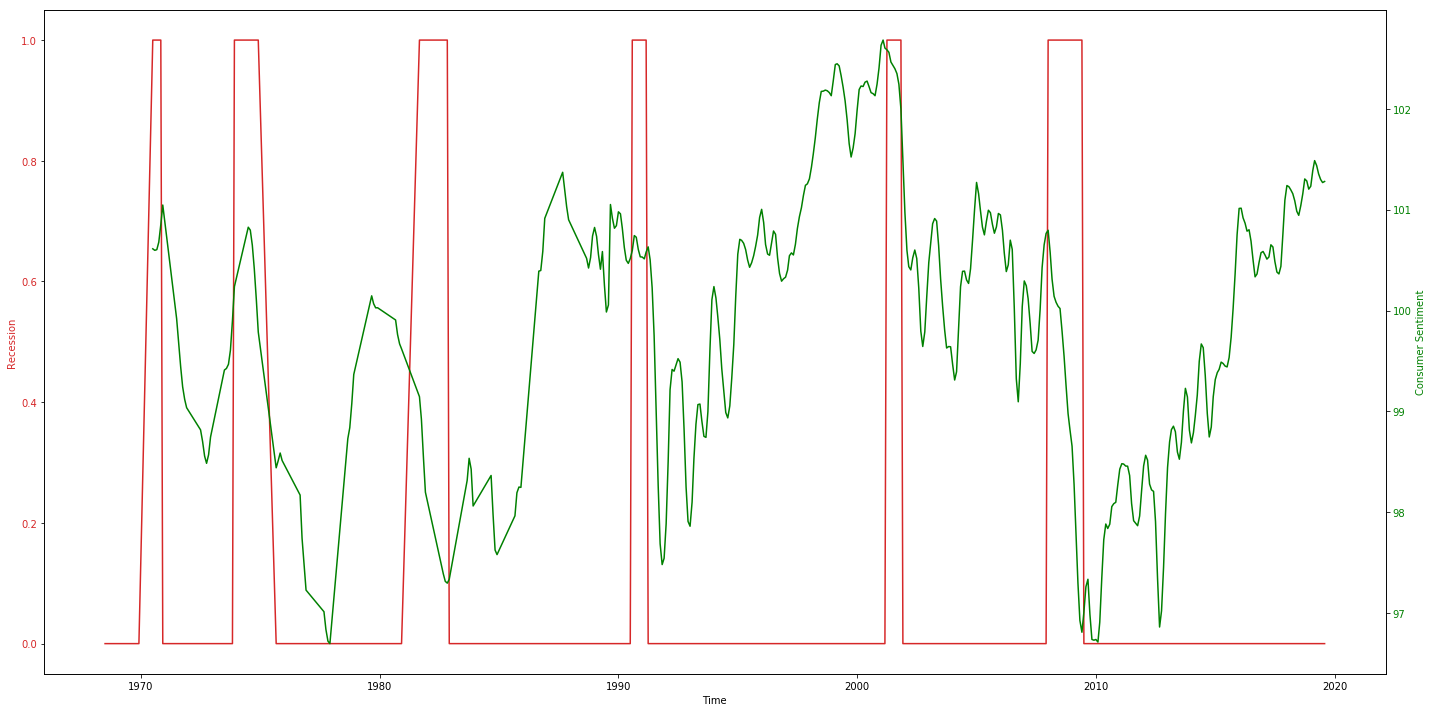

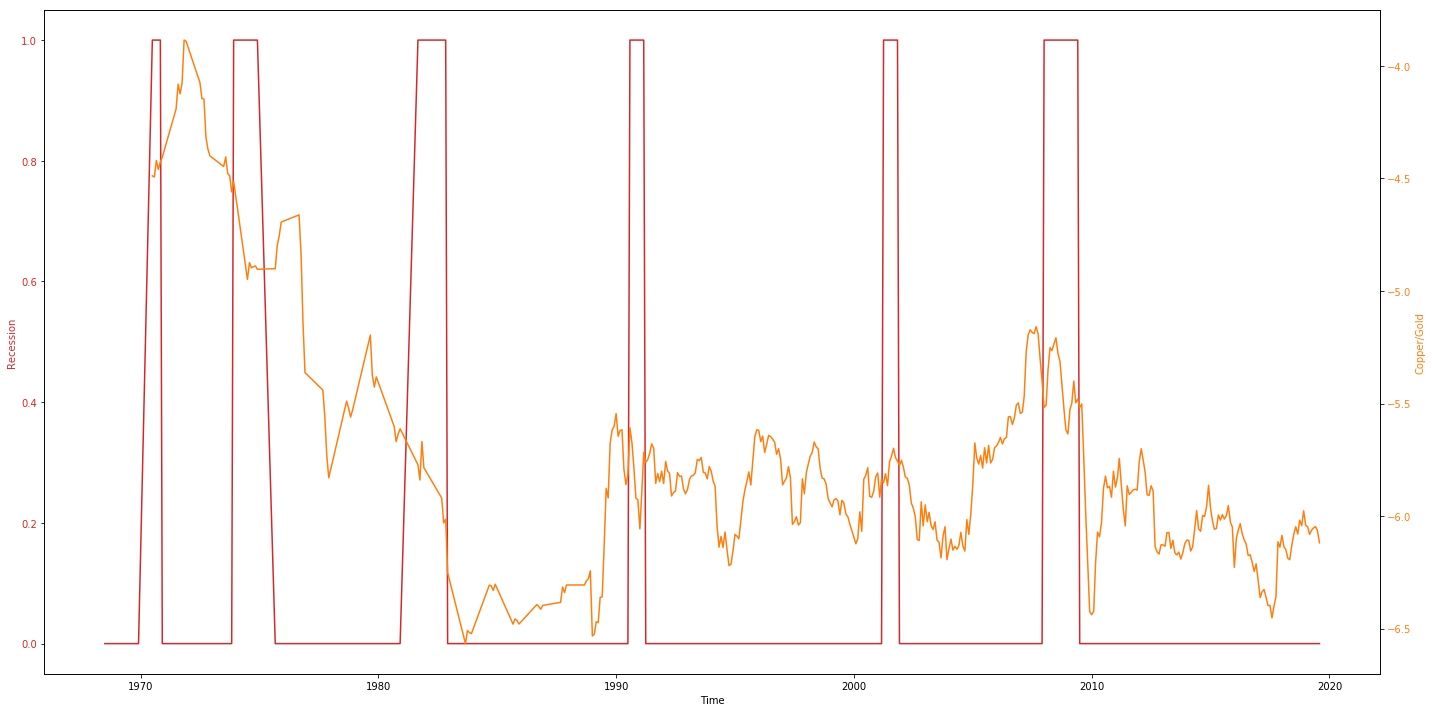

In [23]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(df['Date'], df['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Spread', color=color)  
ax2.plot(df['Date'], df['10Y-3M 12M Forward'], color='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.axhline(0, color="black")
plt.show()

fig2, ax3 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax3.set_xlabel('Time')
ax3.set_ylabel('Recession', color=color)
ax3.plot(df['Date'], df['Recession'], color=color)
ax3.tick_params(axis='y', labelcolor=color)

ax4 = ax3.twinx()  

color = 'tab:blue'
ax4.set_ylabel('Consumer Sentiment', color='green')  
ax4.plot(df['Date'], df['C Sentiment 12M Forward'], color='green')
ax4.tick_params(axis='y', labelcolor='green')

fig2.tight_layout()
plt.show()

fig3, ax5 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax5.set_xlabel('Time')
ax5.set_ylabel('Recession', color=color)
ax5.plot(df['Date'], df['Recession'], color=color)
ax5.tick_params(axis='y', labelcolor=color)

ax6 = ax5.twinx()  

color = 'tab:orange'
ax6.set_ylabel('Copper/Gold', color=color)  
ax6.plot(df['Date'], df['C/G 12M Forward'], color=color)
ax6.tick_params(axis='y', labelcolor=color)

fig3.tight_layout()
plt.show();

Overall, looks like the 6 month forward spread is best indicator of recession

## Logistic Regression for Recession Probabilities

Let's start with the baseline New York Federal Reserve Model. Percent chance recession is simply a function of the 10Y-3M Spread

In [117]:
df_base = df[['Date','Recession','10Y-3M 6M Forward']].copy()
df_base.dropna(inplace = True)

In [118]:
#2/3 train, 1/3 test split
cutoff = round(len(df_base) * 0.666)
cutoff

306

In [119]:
cross_validation = df_base[:cutoff]
cross_validation = cross_validation.reset_index(drop = True)
test = df_base[cutoff:]
test = test.reset_index(drop = True)

In [120]:
test.head()

,Date,Recession,10Y-3M 6M Forward
0,2006-11-01,0,0.39
1,2006-12-01,0,0.32
2,2007-01-01,0,0.14
3,2007-02-01,0,-0.08
4,2007-03-01,0,-0.09


In [121]:
y_train = cross_validation.Recession
y_test = test.Recession
X_train = cross_validation[['10Y-3M 6M Forward']]
X_test = test[['10Y-3M 6M Forward']]

In [122]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Let's evaluate the model's ability to predict a recession in a 6-month window, starting 6 months from now

In [123]:
y_test = y_test.to_numpy()

In [124]:
def rolling_6(y_test):
    """
    Helper function to convert y_test to rolling 6 month window. 
    Returns numpy array: If recession occurs in 6 month window from index, returns 1. Otherwise, returns 0
    """
    rec_6_months = []
    
    for i in range(len(y_test)):
        if np.sum(y_test[i:i+6]) > 0:
            rec_6_months.append(1)    
        
        else:
            rec_6_months.append(0)
                
    return np.array(rec_6_months)
    

In [125]:
y_test_custom = rolling_6(y_test)
y_train_custom = rolling_6(y_train)

In [132]:
#Use preconfigured C, not just 0.95
logit = LogisticRegression()
logit.fit(X_train, y_train_custom)
y_predict = logit.predict(X_test)
y_probs_1 = logit.predict_proba(X_test)
print("Test set AUC: {:6.2f}%".format(roc_auc_score(y_test_custom, y_probs_1[:,1])))
print("Default Threshold: 0.5")
print("Test Set Precision: {:6.4f}".format(precision_score(y_test_custom, y_predict)))

Test set AUC:   0.65%
Default Threshold: 0.5
Test Set Precision: 0.3636


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [133]:
def make_confusion_matrix(model, threshold=0.2):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    default_confusion = confusion_matrix(y_test_custom, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(default_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['Growth', 'Recession'],
           yticklabels=['Growth', 'Recession']);
    plt.xlabel('prediction')
    plt.ylabel('actual')
    print("F1: {:6.4f}, Precision: {:6.4f},   Recall: {:6.4f}".format(fbeta_score(y_test_custom, y_predict, beta = 1),
                                                                           precision_score(y_test_custom, y_predict), 
                                                                           recall_score(y_test_custom, y_predict)))

F1: 0.4151, Precision: 0.3667,   Recall: 0.4783


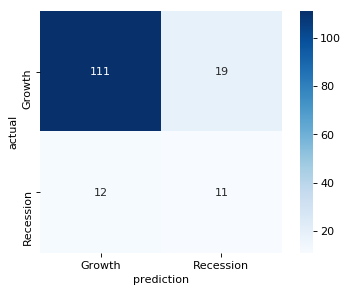

In [134]:
make_confusion_matrix(logit, 0.2)

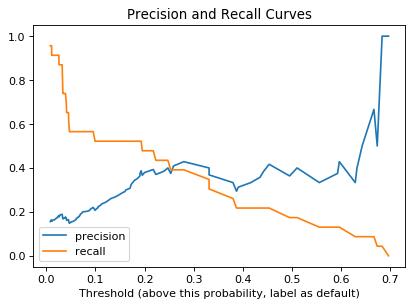

In [135]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test_custom, 
                                                                        logit.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as default)');
plt.title('Precision and Recall Curves')

fig_1 = plt.gcf()
fig_1.savefig('Data/logit_curves_1', format='png');

Baseline Federal Reserve Model w/ Threshold of 0.2:  
F1: 0.333  
Precision: 0.2449 
Recall: 0.5217


Now let's add two extra features to see if model improves

In [136]:
df_logit = df[['Date','Recession','10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']].copy()
df_logit.dropna(inplace = True)
#452 months

In [137]:
cutoff = round(len(df_logit) * 0.666)
cutoff

306

In [138]:
cross_validation = df_logit[:cutoff]
cross_validation = cross_validation.reset_index(drop = True)
test = df_logit[cutoff:]
test = test.reset_index(drop = True)

In [139]:
test.head()

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,C/G 6M Forward
0,2006-11-01,0,0.39,99.594993,-5.195529
1,2006-12-01,0,0.32,99.574672,-5.172351
2,2007-01-01,0,0.14,99.610052,-5.184204
3,2007-02-01,0,-0.08,99.706203,-5.189537
4,2007-03-01,0,-0.09,100.014689,-5.158429


In [140]:
y_train = cross_validation.Recession
y_test = test.Recession
X_train = cross_validation[['10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']]
X_test = test[['10Y-3M 6M Forward','C Sentiment 6M Forward','C/G 6M Forward']]

In [141]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [142]:
y_test = y_test.to_numpy()

In [143]:
y_test_custom = rolling_6(y_test)
y_train_custom = rolling_6(y_train)

In [144]:
logit_2 = LogisticRegression(C = 0.95)
logit_2.fit(X_train, y_train_custom)
y_predict_2 = logit_2.predict(X_test)
y_probs_2 = logit_2.predict_proba(X_test)
print("The score for logistic regression is")
#score returns mean accuracy
print("Test set AUC: {:6.2f}%".format(roc_auc_score(y_test_custom, y_probs_2[:,1])))
print("Default threshold: 0.5")
print("Test set Precision: {:6.4f}".format(precision_score(y_test_custom, y_predict_2)))

The score for logistic regression is
Test set AUC:   0.71%
Default threshold: 0.5
Test set Precision: 0.3846


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1: 0.5000, Precision: 0.4800,   Recall: 0.5217


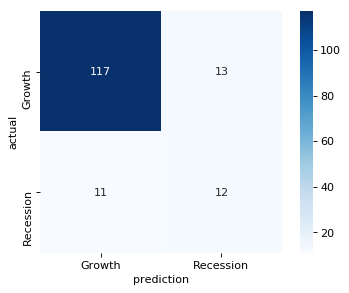

In [145]:
make_confusion_matrix(logit_2, 0.2)

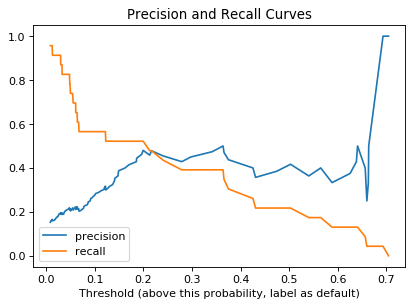

In [146]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test_custom, 
                                                                        logit_2.predict_proba(X_test)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as default)');
plt.title('Precision and Recall Curves')

fig_2 = plt.gcf()
fig_2.savefig('Data/logit_curves_2', format='png');

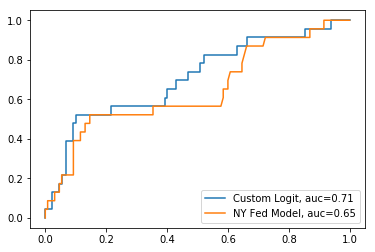

In [147]:
plt.figure(0).clf()

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_2[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_2[:,1])
plt.plot(fpr,tpr,label="Custom Logit, auc="+str(round(auc,2)))

fpr, tpr, thresh = metrics.roc_curve(y_test_custom, y_probs_1[:,1])
auc = metrics.roc_auc_score(y_test_custom, y_probs_1[:,1])
plt.plot(fpr,tpr,label="NY Fed Model, auc="+str(round(auc,2)))

plt.legend(loc='lower right');

In [148]:
np.save('Data/y_probs_1', y_probs_1)
np.save('Data/y_probs_2', y_probs_2)
np.save('Data/y_test_custom', y_test_custom)

Looks like the extra features, gold/copper and consumer sentiment, helped the new model outperform the 
baseline Fed model!

## Plotting recession probabilities 6 months in future against actual recession

In [149]:
rec_probs = logit_2.predict_proba(X_test)
temp = pd.DataFrame(rec_probs)
temp['Date'] = test['Date']

In [150]:
temp.head()

,0,1,Date
0,0.525851,0.474149,2006-11-01
1,0.497151,0.502849,2006-12-01
2,0.435076,0.564924,2007-01-01
3,0.361719,0.638281,2007-02-01
4,0.359288,0.640712,2007-03-01


In [151]:
test = pd.concat([test, temp], axis=1)

In [152]:
test.dropna(inplace = True)
test.tail()

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,C/G 6M Forward,0,1,Date
148,2019-04-01,0,0.90,101.342390,-6.126769,0.813567,0.186433,2019-04-01
149,2019-05-01,0,0.79,101.237183,-6.083086,0.783089,0.216911,2019-05-01
150,2019-06-01,0,0.46,101.072907,-6.188920,0.702007,0.297993,2019-06-01
151,2019-07-01,0,0.34,100.876346,-6.163211,0.658503,0.341497,2019-07-01
152,2019-08-01,0,0.29,100.928805,-6.107702,0.635877,0.364123,2019-08-01


In [153]:
test.head()

,Date,Recession,10Y-3M 6M Forward,C Sentiment 6M Forward,C/G 6M Forward,0,1,Date
0,2006-11-01,0,0.39,99.594993,-5.195529,0.525851,0.474149,2006-11-01
1,2006-12-01,0,0.32,99.574672,-5.172351,0.497151,0.502849,2006-12-01
2,2007-01-01,0,0.14,99.610052,-5.184204,0.435076,0.564924,2007-01-01
3,2007-02-01,0,-0.08,99.706203,-5.189537,0.361719,0.638281,2007-02-01
4,2007-03-01,0,-0.09,100.014689,-5.158429,0.359288,0.640712,2007-03-01


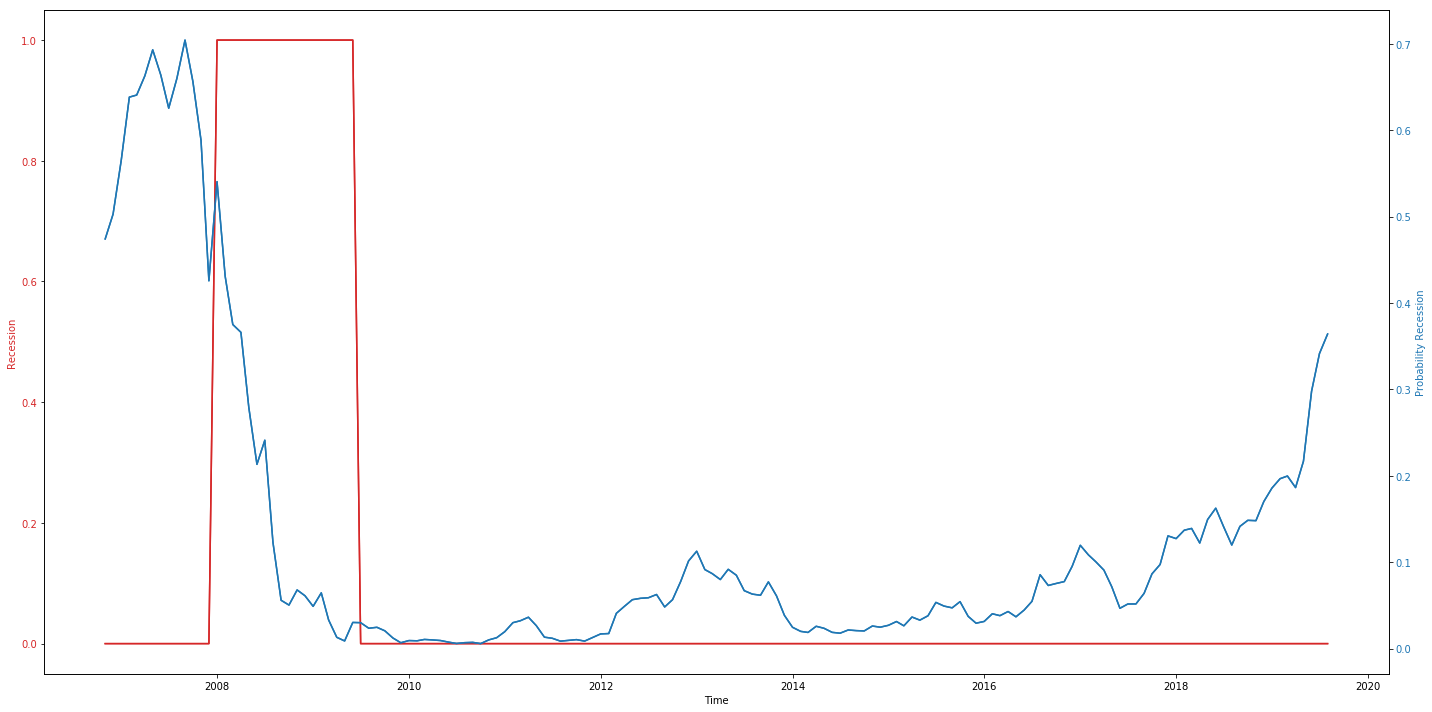

In [154]:
fig, ax1 = plt.subplots(figsize=(20,10))

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('Recession', color=color)
ax1.plot(test['Date'], test['Recession'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Probability Recession', color=color)  
ax2.plot(test['Date'], test[1], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()